# Instalacja GLPK

In [4]:
!wget -N https://ftp.gnu.org/gnu/glpk/glpk-5.0.tar.gz
!tar -xf glpk-5.0.tar.gz
# Kompilacja i instalacja
!echo "Rozpoczynam kompilację. Może to potrwać kilka minut..."
!cd glpk-5.0/ && ./configure 1> /dev/null && make 1> /dev/null && make install 1> /dev/null
# Rejestracja biblioteki libglpk
!echo /usr/local/lib/libglpk.so.40 | tee /etc/ld.so.conf.d/libglpk.con && ldconfig
!echo "Zakończone"


# Definiujemy nowe "cell magic" dla uproszczenia uruchamiania solvera Glpsol

import re
import tempfile
import subprocess
from pathlib import Path
from IPython import get_ipython
from IPython.display import HTML, display
from IPython.core.magic import Magics, cell_magic, magics_class
import shlex
import html
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

HIGHLIGHT_RULES = {
    'color:green': re.compile(r'\b((?:INTEGER)?\s*OPTIMAL[\s\w]*?\n)\b', re.IGNORECASE),
    'color:red': re.compile(r'\b(INFEASIBLE|UNBOUNDED)\b', re.IGNORECASE),
    'color:#FF0000': re.compile(r'\b(MathProg model processing error)\b', re.IGNORECASE),
    'color:#c76e00': re.compile(r'((?:\bobjective:.*?\n)|(?:\bDisplay\sstatement.*?\n))', re.IGNORECASE),
}

def syntax_highlight(text):
    """
    Applies syntax highlighting to the glpsol output by wrapping matched patterns with span tags.
    """
    # Escape HTML special characters
    escaped_text = html.escape(text)

    # Apply highlighting rules
    for style, pattern in HIGHLIGHT_RULES.items():
        replacement = rf'<span style="{style}">\1</span>'
        escaped_text = pattern.sub(replacement, escaped_text)

    # Return the formatted HTML
    return f'<pre style="max-width: 800px; white-space: pre-wrap; font-family: monospace;">{escaped_text}</pre>'


@magics_class
class GlpkMagic(Magics):
    @cell_magic
    def glpsol(self, line, cell):
        """
        Cell magic to run glpsol on the provided LP model.

        Usage:
        %%glpsol [glpsol options]
        <LP model>
        """
        lp_file = None
        sol_file = None
        try:
            with tempfile.TemporaryDirectory() as tmpdir:
                tmp_path = Path(tmpdir)
                lp_file = tmp_path / "model.lp"
                sol_file = tmp_path / "model.sol"

                # Write the LP model to the temporary .lp file
                lp_file.write_text(cell, encoding='utf-8')

                # Parse command-line options safely
                cmd_options = shlex.split(line)
                cmd = ['glpsol'] + cmd_options + ['-m', str(lp_file), '-o', str(sol_file)]

                # Run glpsol and capture output
                result = subprocess.run(
                    cmd,
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    text=True,
                    check=True
                )

                output = result.stdout

                # Check if the solution file exists and read its content
                if sol_file.exists():
                    sol_content = sol_file.read_text(encoding='utf-8')
                    output += ('\n' + '-' * 80 + '\n') + sol_content
                else:
                    logger.warning(f"Expected solution file {sol_file} not found.")

        except subprocess.CalledProcessError as e:
            # Capture and process error output
            output = e.stdout + '\n' + e.stderr
            processed_output = self._process_error_output(output, cell, lp_file)
            highlighted = syntax_highlight(processed_output)
            display(HTML(highlighted))
            raise RuntimeError(processed_output) from None
        except Exception as e:
            # Handle unexpected exceptions
            logger.error("An unexpected error occurred while running glpsol.", exc_info=True)
            display(HTML(f'<span style="color:red;">An unexpected error occurred: {e}</span>'))
            return

        # Apply syntax highlighting and display
        highlighted = syntax_highlight(output)
        display(HTML(highlighted))

    def _process_error_output(self, output, cell, lp_file):
        """
        Processes glpsol error output to map errors back to the LP model lines.
        """
        processed = []
        input_lines = cell.split('\n')
        lp_filename = lp_file.name if lp_file else 'model.lp'

        for ln in output.split('\n'):
            if ln.startswith(f"{lp_filename}:"):
                processed.append(f'\n{ln}')
                tail = ln[len(lp_filename) + 1:]
                match = re.match(r"^\d+", tail)
                if match:
                    orig_line_index = int(match.group()) - 1
                    if 0 <= orig_line_index < len(input_lines):
                        processed.append(input_lines[orig_line_index])
            else:
                processed.append(ln)

        return '\n'.join(processed)

# Register the magic with IPython
ip = get_ipython()
if ip:
    ip.register_magics(GlpkMagic)
else:
    logger.error("IPython environment not found. The GlpkMagic was not registered.")

--2025-11-17 14:40:01--  https://ftp.gnu.org/gnu/glpk/glpk-5.0.tar.gz
Resolving ftp.gnu.org (ftp.gnu.org)... 209.51.188.20, 2001:470:142:3::b
Connecting to ftp.gnu.org (ftp.gnu.org)|209.51.188.20|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘glpk-5.0.tar.gz’ not modified on server. Omitting download.

Rozpoczynam kompilację. Może to potrwać kilka minut...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.1 is not a sy

# Treść zadania 9

Proszę rozwiązać jedno, wybrane zadanie spośród zadań 8, 9 i 10 z zestawu 2 (progr. liniowe i całkowitoliczbowe).

Za zad. 8 można otrzymać ocenę 4.5, za pozostałe 5.0.

Należy przedstawić zarówno kod rozwiązania, jak i wyniki oraz stosowne komentarze.

Proszę klarownie wyjaśnić znaczenie zmiennych decyzyjnych, f. celu oraz ograniczeń.

Każda osoba zgłasza jedno rozwiązanie w postaci pliku *.ipynb

W pliku tym należy umieścić kod oraz stosowne komentarze, wnioski i uwagi. Te ostatnie w komórkach z tekstem (markdown).

 Liczba 1210 jest przykładem liczby **autobiograficznej**, gdyż jej pierwsza cyfra jest zarazem liczbą zer w jej zapisie dziesiętnym, druga - liczbą jedynek i tak dalej, aż do ostatniej, która jest liczbą trójek.

Przykładowo, 7-cyfrową liczbą autobiograficzną jest 3211000, ponieważ ma 3 zera, 2 jedynki, 1 dwójkę, 1 trójkę, 0 czwórek, 0 piątek i 0 szóstek.

Napisz program całokowitoliczbowy, który znajdzie 10-cyfrową liczbę autobiograficzną.

*Wskazówka. Rozważ użycie zmiennych binarnych przypisujących każdej pozycji w liczbie dokładnie jedną cyfrę.*



### Zmienne Decyzyjne:
- $x_{i,v} \in \{0,1\}$ — zmienna binarna; $x_{i,v} = 1$ jeśli na pozycji $i$ znajduje się cyfra $v$
- $d_i \in \{0,1,...,9\}$ — cyfra na pozycji $i$

### Ograniczenia:

1. **Jedna cyfra na pozycję** (dla każdego $i \in \{0,...,9\}$):
   $$\sum_{v=0}^{9} x_{i,v} = 1$$

2. **Definicja wartości cyfry** (dla każdego $i \in \{0,...,9\}$):
   $$d_i = \sum_{v=0}^{9} v \cdot x_{i,v}$$

3. **Warunek autobiograficzny** — KLUCZOWY (dla każdego $v \in \{0,...,9\}$):
   $$d_v = \sum_{i=0}^{9} x_{i,v}$$
   
   Interpretacja: Liczba cyfry $v$ w całej liczbie musi równać się wartości na pozycji $v$.

4. **Liczba nie może zaczynać się od zera**:
   $$\sum_{v=0}^{9} v \cdot x_{0,v} \geq 1$$

### Funkcja Celu:
$$\text{minimize} \quad \sum_{i=0}^{9} d_i$$



In [1]:
%%glpsol

set I := 0..9;      # pozycje w liczbie
set V := 0..9;      # możliwe cyfry


# Zmienne binarne: x[i,v] = 1 gdy na pozycji i stoi cyfra v
var x{i in I, v in V}, binary;


# Zdefiniowane cyfry d[i] = cyfra na pozycji i
var d{i in I}, integer, >= 0, <= 9;


# 1) Na każdej pozycji musi być dokładnie jedna cyfra
s.t. OneDigit{i in I}:
    sum{v in V} x[i,v] = 1;


# 2) Definicja cyfry d[i]
s.t. DigitValue{i in I}:
    d[i] = sum{v in V} v * x[i,v];


# 3) Liczba wystąpień cyfry v musi być równa d[v]
# To jest GŁÓWNY warunek autobiograficzny
s.t. Autobiographical{v in V}:
    d[v] = sum{i in I} x[i,v];


# 4) Liczba musi być 10-cyfrowa → pierwsza cyfra nie może być 0
s.t. NonZeroFirst:
    sum{v in V} v * x[0,v] >= 1;


# Funkcja celu — minimalizujemy sumę cyfr
minimize Obj: sum{i in I} d[i];


# Wynik
solve;


printf "Autobiograficzna liczba 10-cyfrowa = ";
for{i in I} {
    printf "%d", d[i];
}
printf "\n";


end;


UsageError: Cell magic `%%glpsol` not found.


Znalezione Rozwiązanie

**Liczba autobiograficzna: 6210001000**

## Wnioski
1. **Suma cyfr = liczba pozycji**: Dla 10-cyfrowej liczby autobiograficznej, suma wszystkich cyfr zawsze równa się 10. Wynika to z faktu, że każda pozycja reprezentuje liczbę jej własnych wystąpień.

2. 10-cyfrową liczbą autobiograficzną jest **6210001000**.
   - Pozycja 0: cyfra 6 → jest 6 zer ✓
   - Pozycja 1: cyfra 2 → są 2 jedynki ✓
   - Pozycja 2: cyfra 1 → jest 1 dwójka ✓
   - Pozycje 3-5: cyfra 0 → w tych pozycjach nie pojawia się żadna cyfra (z których byłyby liczby) ✓
   - Pozycje 6-9: cyfry 1,0,0,0 → liczba jedynek = 1 ✓

3. **Liczby autobiograficzne są rzadkie**: Dla każdej długości liczby istnieje co najwyżej kilka (lub nawet tylko jedna) liczba autobiograficzna.

4. **Podejście do problemu**: Problem formułuje się naturalnie jako Integer Linear Program, a solvery (takie jak GLPK) potrafią go szybko rozwiązać, nawet dla większych wymiarów.


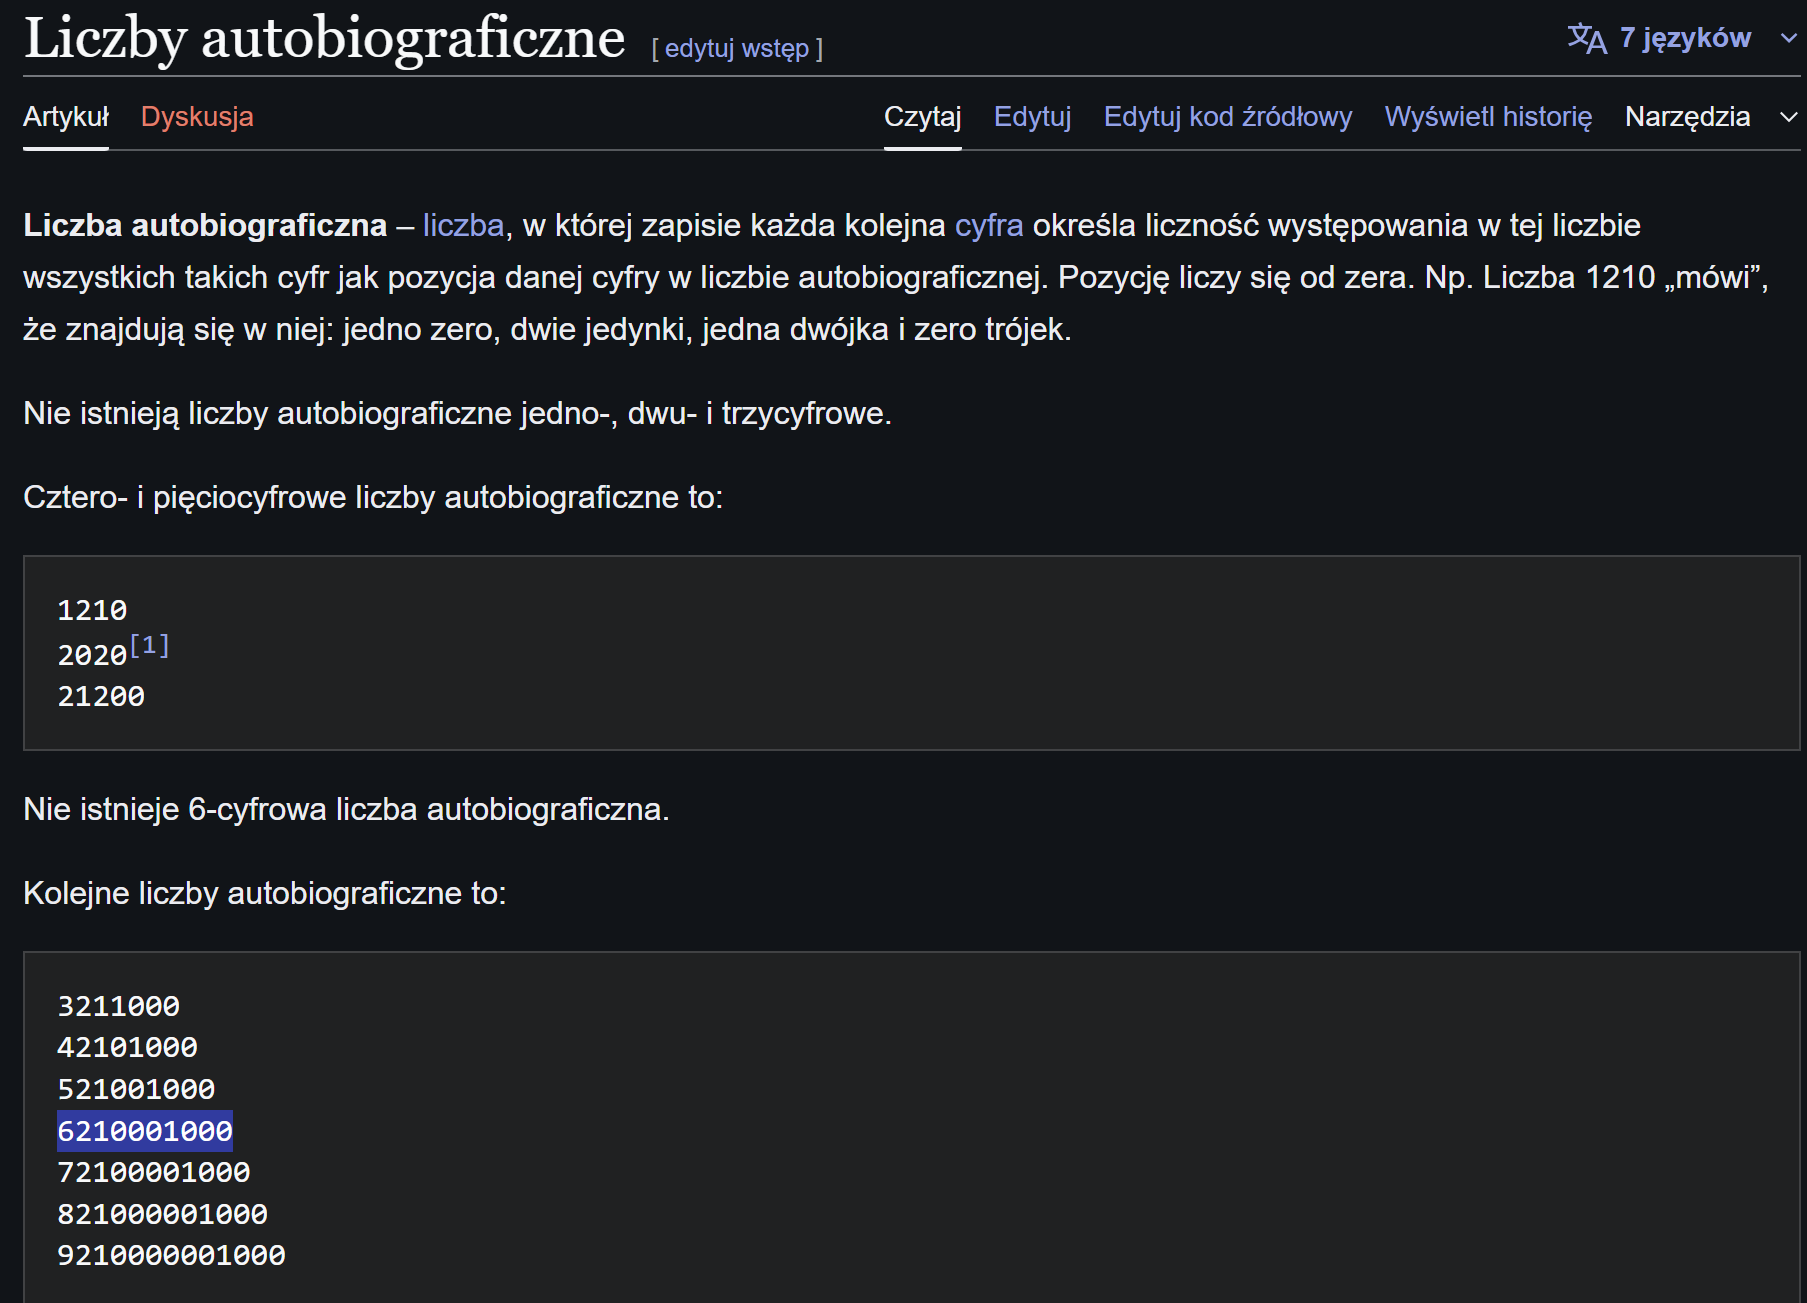